In [1]:
import sys
print(sys.executable)
print(sys.version)

/u/60/pereire1/unix/miniconda3/envs/noqula/bin/python
3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]


In [2]:
import tensorflow as tf
print(tf.__version__)


2025-12-01 17:02:21.699266: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 17:02:21.709692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764601341.720827  776924 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764601341.723889  776924 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764601341.732143  776924 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

2.19.0


In [3]:
import numpy as np
import math as m
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow import keras

In [4]:
# Generate input data


# Fidelity calculation functions

def fidelity_imag(y_pred1, y_true1):
    y_pred_imag = y_pred1
    y_true_imag = y_true1
    ai = y_pred_imag
    bi = y_true_imag
    ci = ai * bi
    F_imag = (np.mean(ci) - np.mean(ai) * np.mean(bi)) / (
        (np.mean(np.square(ai)) - np.square(np.mean(ai))) *
        (np.mean(np.square(bi)) - np.square(np.mean(bi))) 
        )** 0.5
    return F_imag

# Create neural network model
def create_model(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    x = Dense(80, activation="relu", kernel_initializer="glorot_uniform")(x_input)
    x = Dense(60, activation="relu", kernel_initializer="glorot_uniform")(x)
    x = Dense(40, activation="relu", kernel_initializer="glorot_uniform")(x)
    output = Dense(2)(x)
    model = Model(x_input, output)
    return model

def create_model1(input_shape): #model to prevent overfitting
    # Input layer
    x_input = Input(shape=input_shape, name="x_input")
    # First Dense layer with L2 regularization and Dropout
    x = Dense(10*80, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.0001))(x_input)
    x = Dropout(0.4)(x)  # Dropout with a rate of 0.3
    # Second Dense layer with L2 regularization and Dropout
    x = Dense(10*60, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.3)(x)  # Dropout with a rate of 0.3
    # Third Dense layer with L2 regularization and Dropout
    x = Dense(10*40, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.3)(x)  # Dropout with a rate of 0.3
    # Output layer
    output = Dense(2)(x)
    # Create and return the model
    model = Model(x_input, output)
    return model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2

def create_split_head_model(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    
    # Shared layers
    x = Dense(40, activation="relu")(x_input)
    x = Dropout(0.2)(x)
    x = Dense(20, activation="relu")(x)

    # Branch 1 - onsite loss
    loss_branch = Dense(10, activation="relu")(x)
    loss_output = Dense(1, name="loss_output")(loss_branch)

    # Branch 2 - puc phase
    phase_branch = Dense(10, activation="relu")(x)
    phase_output = Dense(1, name="phase_output")(phase_branch)

    model = Model(inputs=x_input, outputs=[phase_output,loss_output])
    return model

def create_improved_model(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    
    x = Dense(64, kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(32, kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(16, kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
    x = LeakyReLU()(x)
    
    output = Dense(2, name="output")(x)  # for phase and loss prediction
    
    model = Model(inputs=x_input, outputs=output)
    return model


In [5]:
# Add noise to data
def adding_noise(p1, q1, noise_std):
    noise1 = np.random.normal(0, noise_std, size=p1.shape)
    noise2 = np.random.normal(0, noise_std, size=q1.shape)
    p2 = np.concatenate([p1, p1 + noise1], axis=0)
    q2 = np.concatenate([q1, q1 + noise2], axis=0)  
    indices = np.arange(len(p2))
    np.random.shuffle(indices)
    return p2[indices], q2[indices]



def adding_noise_log(p1, q1, noise_std):
    noise1 = np.random.lognormal(mean=0.0, sigma=noise_std, size=p1.shape)
    noise2 = np.random.lognormal(mean=0.0, sigma=noise_std, size=q1.shape)
    p2 = p1 * noise1  # Multiplicative noise keeps values non-negative
    q2 = q1 * noise2
    return p2, q2

In [6]:
import numpy as np

def filter_by_puc_phase_ring_major(datay0, datay1, X, ref_puc_phases, epsilon):
    datay0 = np.array(datay0)
    datay1 = np.array(datay1)
    ref_puc_phases = np.array(ref_puc_phases)
    epsilon = np.array(epsilon)

    n_datapoints, n_rings = datay0.shape
    assert datay1.shape == datay0.shape
    assert X.shape[0] == n_datapoints * n_rings
    assert ref_puc_phases.shape[0] == epsilon.shape[0] == n_rings

    chosendatay0 = []
    chosendatay1 = []
    chosenX = []

    for i in range(n_datapoints):
        for j in range(n_rings):
            if abs(datay0[i, j] - ref_puc_phases[j]) <= epsilon[j]:
                idx = i * n_rings + j
                chosendatay0.append(datay0[i, j])
                chosendatay1.append(datay1[i, j])
                chosenX.append(X[idx])

    return (
        np.array(chosendatay0),
        np.array(chosendatay1),
        np.array(chosenX)
    )


In [7]:
import numpy as np
import os

# Define folder and file paths

file_pathy0 = os.path.join( "finalized_resonant_freqs_wrt_ref_phase_using_fsr_and_puc_phases.txt")
file_pathy1 = os.path.join("random_oniste_losses_inGHz.txt")
file_pathx = os.path.join("full.txt")  # X data
#file_pathx = os.path.join("compensated_spectral_data.txt")  # X data

# Load Y components (assuming space-separated values)
datay0 = np.loadtxt(file_pathy0, delimiter=" ")  # shape: (rows, cols)
datay1 = np.loadtxt(file_pathy1, delimiter=" ")

# Flatten both to 1D arrays (row-major)
datay0_flat = datay0.flatten()
datay1_flat = datay1.flatten()

# Stack them into a 2D array: shape (N, 2)
y = np.stack((datay0_flat, datay1_flat), axis=1)

# Load X data (2D)
X11 = np.loadtxt(file_pathx, delimiter=" ")
X = 10.**(X11/10)

# Print shapes to verify
print("X shape:", X.shape)     # e.g., (samples, features)
print("y shape:", y.shape)     # e.g., (samples, 2)


X shape: (2400, 40)
y shape: (2400, 2)


In [8]:
epsilon = np.array([5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5])/1.
#epsilon = np.array([6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0])/1.

In [9]:
chosen0, chosen1, chosenX = filter_by_puc_phase_ring_major(datay0, datay1, X, np.zeros_like(epsilon), epsilon)
print("shape of chosendatay0:", chosen0.shape)
print("shape of chosendatay1:", chosen1.shape)
print("shape of chosenX:\n", chosenX.shape)

shape of chosendatay0: (1533,)
shape of chosendatay1: (1533,)
shape of chosenX:
 (1533, 40)


In [10]:
choseny = np.stack((chosen0, chosen1), axis=1)
print("choseny shape:", choseny.shape)

choseny shape: (1533, 2)


In [11]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(chosenX, choseny, test_size=0.2)

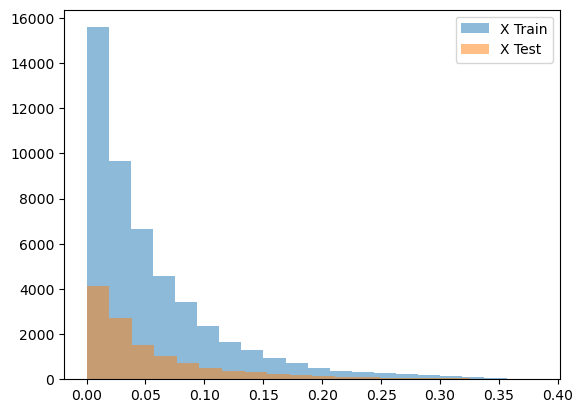

In [12]:
import matplotlib.pyplot as plt
plt.hist(X_train.flatten(), bins=20, alpha=0.5, label="X Train")
plt.hist(X_test.flatten(), bins=20, alpha=0.5, label="X Test")
plt.legend()
plt.show()

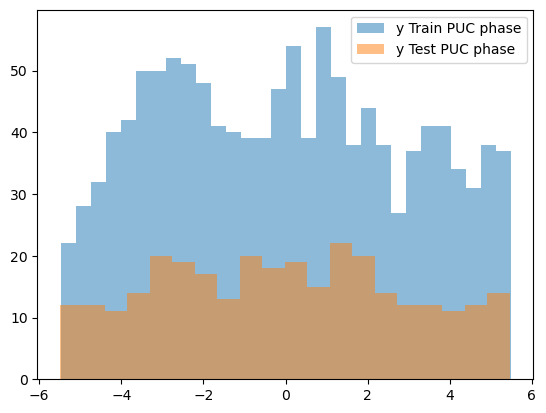

In [13]:
import matplotlib.pyplot as plt
plt.hist(y_train[:,0].flatten(), bins=30, alpha=0.5, label="y Train PUC phase")
plt.hist(y_test[:,0].flatten(), bins=20, alpha=0.5, label="y Test PUC phase")
plt.legend()
plt.show()

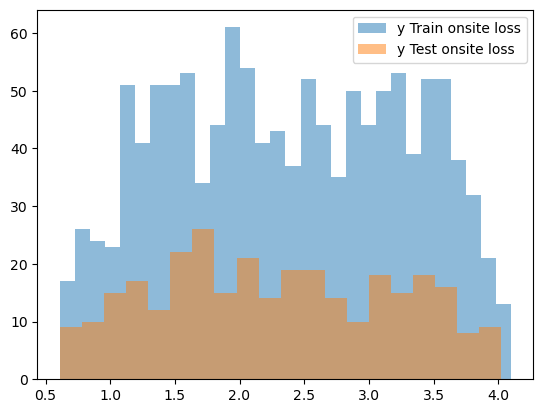

In [14]:
import matplotlib.pyplot as plt
plt.hist(y_train[:,1].flatten(), bins=30, alpha=0.5, label="y Train onsite loss")
plt.hist(y_test[:,1].flatten(), bins=20, alpha=0.5, label="y Test onsite loss")
plt.legend()
plt.show()

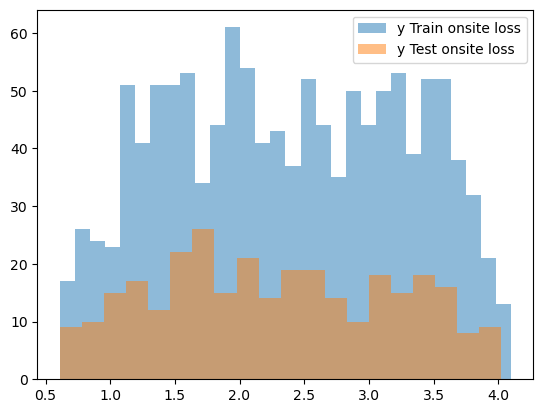

In [15]:
import matplotlib.pyplot as plt
plt.hist(y_train[:,1].flatten(), bins=30, alpha=0.5, label="y Train onsite loss")
plt.hist(y_test[:,1].flatten(), bins=20, alpha=0.5, label="y Test onsite loss")
plt.legend()
plt.show()

In [16]:
#from sklearn.preprocessing import StandardScaler

## Initialize separate scalers for each column
#scaler_col0 = StandardScaler()
#scaler_col1 = StandardScaler()

## Fit-transform each column of training data separately
#y_train_scaled_col0 = scaler_col0.fit_transform(y_train[:, [0]])  # keep 2D
#y_train_scaled_col1 = scaler_col1.fit_transform(y_train[:, [1]])

## Concatenate the scaled columns back together
#y_train_scaled = np.hstack([y_train_scaled_col0, y_train_scaled_col1])

## Transform test data using the same scalers
#y_test_scaled_col0 = scaler_col0.transform(y_test[:, [0]])
#y_test_scaled_col1 = scaler_col1.transform(y_test[:, [1]])
#y_test_scaled = np.hstack([y_test_scaled_col0, y_test_scaled_col1])
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline

target_scaler = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())
y_train0=y_train[:,0].reshape(-1,1)
target_scaler.fit(y_train0)
y_train_scaled0=target_scaler.transform(y_train[:,0].reshape(-1,1))
y_test_scaled0=target_scaler.transform(y_test[:,0].reshape(-1,1))

target_scaler1 = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())
y_train1=y_train[:,1].reshape(-1,1)
target_scaler1.fit(y_train1)
y_train_scaled1=target_scaler1.transform(y_train[:,1].reshape(-1,1))
y_test_scaled1=target_scaler1.transform(y_test[:,1].reshape(-1,1))

y_test_scaled = np.hstack([y_test_scaled0, y_test_scaled1])
y_train_scaled = np.hstack([y_train_scaled0, y_train_scaled1])

In [17]:
scalerx = StandardScaler()
X_train_scaled = scalerx.fit_transform(X_train)
X_test_scaled = scalerx.transform(X_test)

#from sklearn.decomposition import PCA
#pipe = make_pipeline(PCA(n_components = X_train.shape[1]-1))
#pipe.fit(X_train)
#X_train_scaled=pipe.transform(X_train);
#X_test_scaled=pipe.transform(X_test)
#X_train_scaled = X_train
#X_test_scaled = X_test

#y_train_scaled = y_train
#y_test_scaled = y_test

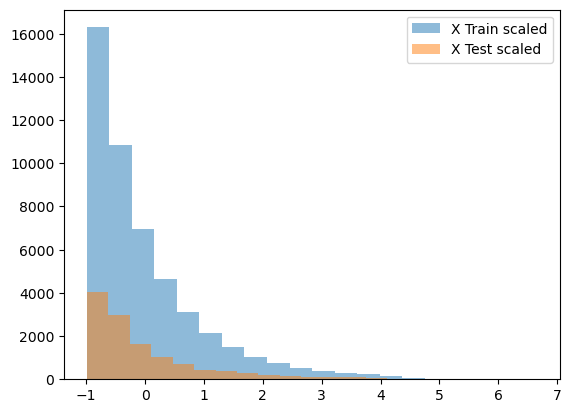

In [18]:
import matplotlib.pyplot as plt
plt.hist(X_train_scaled.flatten(), bins=20, alpha=0.5, label="X Train scaled")
plt.hist(X_test_scaled.flatten(), bins=20, alpha=0.5, label="X Test scaled")
plt.legend()
plt.show()

In [19]:
model = create_model1(input_shape=X_train_scaled.shape[1:])

def learning_rate_scheduler(epoch):
    initial_learning_rate = 0.001  # Initial learning rate
    if epoch <= 1:
        return initial_learning_rate
    else:
        decay = 0.975  # Learning rate decay factor
        lr = initial_learning_rate * (decay ** epoch)
        return lr

#print(f"Test Loss (noise_std={noise_std}):", loss)
model.compile(optimizer="adam", loss="mse")
lr_scheduler_callback = keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=16, validation_split=0.2,callbacks=[lr_scheduler_callback])

loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test Loss :", loss)

# Predictions
y_pred_test = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

# Reshape columns to 2D before inverse transforming
#phase_pred_train = scaler_col0.inverse_transform(y_pred_train[:, 0].reshape(-1, 1))
#loss_pred_train = scaler_col1.inverse_transform(y_pred_train[:, 1].reshape(-1, 1))

#phase_pred_test = scaler_col0.inverse_transform(y_pred_test[:, 0].reshape(-1, 1))
#loss_pred_test = scaler_col1.inverse_transform(y_pred_test[:, 1].reshape(-1, 1))

phase_pred_train = target_scaler.inverse_transform(y_pred_train[:, 0].reshape(-1, 1))
loss_pred_train = target_scaler1.inverse_transform(y_pred_train[:, 1].reshape(-1, 1))

phase_pred_test = target_scaler.inverse_transform(y_pred_test[:, 0].reshape(-1, 1))
loss_pred_test = target_scaler1.inverse_transform(y_pred_test[:, 1].reshape(-1, 1))


print("Phase train predictions shape:", phase_pred_train.shape)
print("Loss train predictions shape:", loss_pred_train.shape)
print("y_train shape:", y_train.shape)

print("Phase test predictions shape:", phase_pred_test.shape)
print("Loss test predictions shape:", loss_pred_test.shape)
print("y_test shape:", y_test.shape)

#print(y_pred_train.shape)
#print(y_train.shape)
#print(y_pred_test.shape)
#print(y_test.shape)

Epoch 1/200


2025-12-01 17:02:38.107734: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3211 - val_loss: 0.1897 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1900 - val_loss: 0.1680 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1696 - val_loss: 0.1393 - learning_rate: 9.5062e-04
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1438 - val_loss: 0.1273 - learning_rate: 9.2686e-04
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1301 - val_loss: 0.1148 - learning_rate: 9.0369e-04
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1256 - val_loss: 0.1118 - learning_rate: 8.8110e-04
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1166 - val_loss: 0.1053 - learning_rate: 8.5907e-04
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1119 - val_loss: 0.1016 - learning_rate: 8.3759e-04
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1019 - val_loss: 0.0940 - learning_rate: 8.1665e-04
Epo

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0245 - val_loss: 0.0263 - learning_rate: 2.4846e-04
Epoch 57/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0242 - val_loss: 0.0246 - learning_rate: 2.4225e-04
Epoch 58/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0230 - val_loss: 0.0236 - learning_rate: 2.3619e-04
Epoch 59/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0233 - val_loss: 0.0238 - learning_rate: 2.3029e-04
Epoch 60/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0232 - val_loss: 0.0236 - learning_rate: 2.2453e-04
Epoch 61/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0235 - val_loss: 0.0225 - learning_rate: 2.1892e-04
Epoch 62/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0215 - val_loss: 0.0227 - learning_rate: 2.1344e-04
Epoch 63/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0220 - val_loss: 0.0234 - learning_rate: 2.0811e-04
Epoch 64/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0220 - val_loss: 0.0222 - learning_rate

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0149 - val_loss: 0.0157 - learning_rate: 6.1732e-05
Epoch 112/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0143 - val_loss: 0.0161 - learning_rate: 6.0188e-05
Epoch 113/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144 - val_loss: 0.0159 - learning_rate: 5.8684e-05
Epoch 114/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147 - val_loss: 0.0159 - learning_rate: 5.7217e-05
Epoch 115/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 - val_loss: 0.0154 - learning_rate: 5.5786e-05
Epoch 116/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144 - val_loss: 0.0155 - learning_rate: 5.4391e-05
Epoch 117/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0140 - val_loss: 0.0156 - learning_rate: 5.3032e-05
Epoch 118/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139 - val_loss: 0.0157 - learning_rate: 5.1706e-05
Epoch 119/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142 - val_loss: 0.0152 - learn

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - val_loss: 0.0144 - learning_rate: 1.5338e-05
Epoch 167/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - val_loss: 0.0143 - learning_rate: 1.4954e-05
Epoch 168/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - val_loss: 0.0143 - learning_rate: 1.4580e-05
Epoch 169/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 - val_loss: 0.0142 - learning_rate: 1.4216e-05
Epoch 170/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0127 - val_loss: 0.0143 - learning_rate: 1.3861e-05
Epoch 171/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - val_loss: 0.0142 - learning_rate: 1.3514e-05
Epoch 172/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - val_loss: 0.0143 - learning_rate: 1.3176e-05
Epoch 173/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - val_loss: 0.0143 - learning_rate: 1.2847e-05
Epoch 174/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0123 - val_loss: 0.0143 - learn

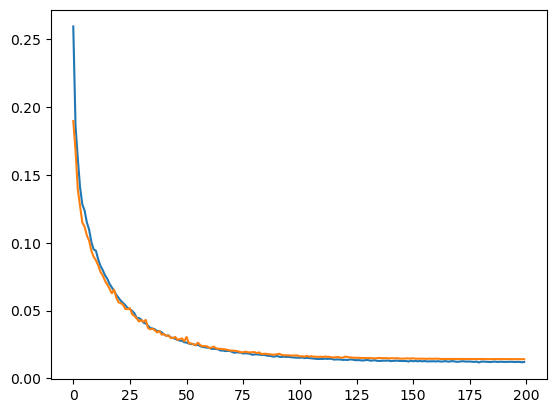

In [20]:
loss_array=np.array(history.history['loss'])
vals_array=np.array(history.history['val_loss'])

plt.plot(loss_array)
plt.plot(vals_array)

In [21]:

phase_train_true = target_scaler.inverse_transform(y_train_scaled[:, 0].reshape(-1, 1))
loss_train_true = target_scaler1.inverse_transform(y_train_scaled[:, 1].reshape(-1, 1))

phase_test_true = target_scaler.inverse_transform(y_test_scaled[:, 0].reshape(-1, 1))
loss_test_true = target_scaler1.inverse_transform(y_test_scaled[:, 1].reshape(-1, 1))

# Fidelity calculation should only use corresponding values
F_real_train = fidelity_imag(phase_pred_train, phase_train_true)
F_real = fidelity_imag(phase_pred_test, phase_test_true)

F_imag_train = fidelity_imag(loss_pred_train, loss_train_true)
F_imag = fidelity_imag(loss_pred_test, loss_test_true)

print("Train Phase Fidelity:", F_real_train)
print("Test Frequencies Fidelity:", F_real)
print("Train Loss Fidelity:", F_imag_train)
print("Test Loss Fidelity:", F_imag)


Train Phase Fidelity: 0.9811410669467555
Test Frequencies Fidelity: 0.9620869195838551
Train Loss Fidelity: 0.9418782425196061
Test Loss Fidelity: 0.9118866787173782


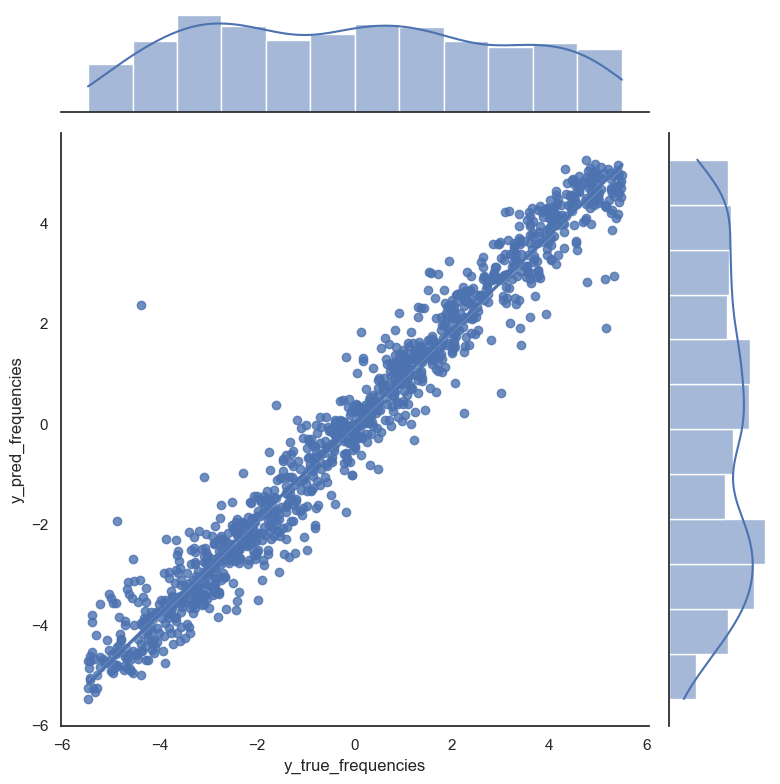

In [22]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_train_scaled and y_pred_train are already defined
y_true_frequencies =   phase_train_true# True phase values
y_pred_frequencies = phase_pred_train  # Predicted phase values

# Convert predictions to pandas dataframe
df_pred_train = pd.DataFrame({
    'y_true_frequencies': y_true_frequencies.ravel(),
    'y_pred_frequencies': y_pred_frequencies.ravel()
})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)

# Jointplot for scatter and regression line with histograms
g = sns.jointplot(
    x='y_true_frequencies',
    y='y_pred_frequencies',
    data=df_pred_train,
    kind="reg",  # Use regression plot type to show the line of best fit
    height=8,    # Adjust the size of the plot (optional)
    ratio=5      # Adjust ratio of scatter plot vs marginal histograms (optional)
)

# Show the plot
plt.show()


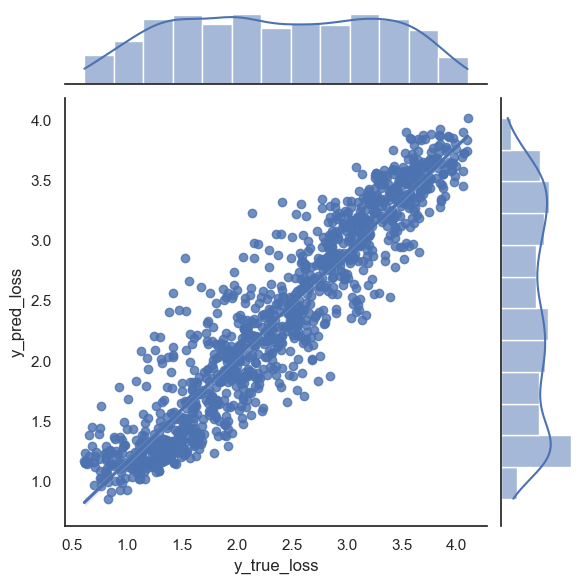

In [23]:
import pandas as pd
import seaborn as sns
y_true_loss = loss_train_true#y_train_scaled[:,1]
y_pred_loss = loss_pred_train#y_pred_train[:,1]

#Convert validation predictions to pandas dataframe
df_pred_train = pd.DataFrame({'y_true_loss':y_true_loss.ravel(), 'y_pred_loss': y_pred_loss.ravel()})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true_loss', y='y_pred_loss', data=df_pred_train, kind="reg")

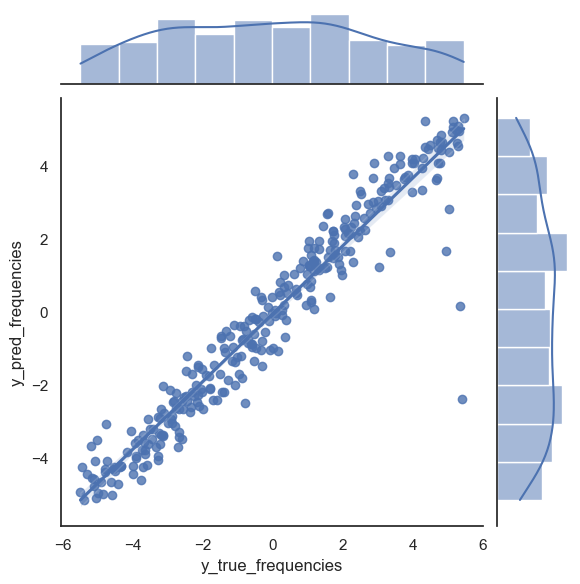

In [24]:
import pandas as pd
import seaborn as sns
y_true_frequencies = phase_test_true#y_test_scaled[:,0]
y_pred_frequencies = phase_pred_test #y_pred_test[:,0]

#Convert validation predictions to pandas dataframe
df_pred_test = pd.DataFrame({'y_true_frequencies':y_true_frequencies.ravel(), 'y_pred_frequencies': y_pred_frequencies.ravel()})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true_frequencies', y='y_pred_frequencies', data=df_pred_test, kind="reg")

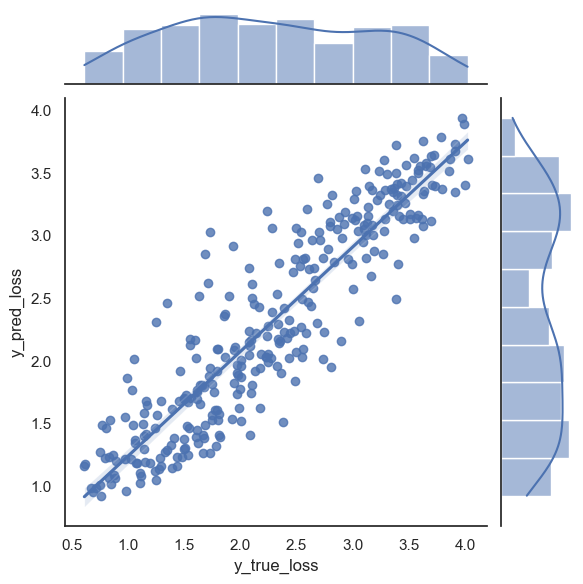

In [25]:
import pandas as pd
import seaborn as sns
y_true_loss = loss_test_true #y_test_scaled[:,1]
y_pred_loss = loss_pred_test#y_pred_test[:,1]

#Convert validation predictions to pandas dataframe
df_pred_test = pd.DataFrame({'y_true_loss':y_true_loss.ravel(), 'y_pred_loss': y_pred_loss.ravel()})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true_loss', y='y_pred_loss', data=df_pred_test, kind="reg")

In [26]:
def eigensys(v,vtilde):
    N = len(v)
    H1 = np.diag(v*1 -vtilde*(1j)) + 0.82*np.eye(N, k=1) + 0.82*np.eye(N, k=-1)
    return H1*2.*np.pi

def gpower(w11, vl, vp, freq1,gamma):
    pw = np.square(np.abs((np.sum(np.conj(vl) * vp / (freq1 - w11+ 1j * gamma), axis=1))))
   # pw = np.abs((np.sum(np.conj(vl) * vp / (freq1 - w11 + 1j * 0.01), axis=1)))
    return pw #/np.pi

def gpower_edited(w11, vl, vp, angular_freq1,gamma):
    #pw = np.square(np.abs((np.sum(np.conj(vl) * vp / (freq1 - w11 + 1j * gamma), axis=1))))
    pw = np.square(np.abs((np.sum(np.conj(vl) * vp / (angular_freq1 - w11+ 1j *gamma), axis=1))))
    return pw

def orthomatrix(vl21, vl22):
    M = np.conj(vl21.T) @ vl22
    return M

def newbiorth1(vl11, vl12,N1):
    M = orthomatrix(vl11, vl12)
    #print(M)
    p, l, u = linalg.lu(M)
    linv = linalg.inv(p @ l)
    uinv = linalg.inv(u)
    vlp1 = linv @ np.conj(np.transpose(vl11))
    vlp2 = vl12 @ uinv
    M1 = vlp1 @ vlp2
    is_biorthogonal = np.allclose(M1, np.eye(N1), atol=1e-10)
    #print(f"Biorthogonality check: {'Passed' if is_biorthogonal else 'Failed'}")
    #print(M1)
    return np.conj(np.transpose(vlp1)), vlp2

In [27]:
file_pathfrequencies = os.path.join("frequencies.txt")
frequencies = 2.*np.pi*np.loadtxt(file_pathfrequencies, delimiter=" ")

frequencies_num = list(enumerate(frequencies))
print("length of frequencies :", len(frequencies))

y_true_l1 = np.concatenate([ loss_train_true,  loss_test_true], axis=0)[:1528].reshape(-1, 8)
y_pred_l1 = np.concatenate([ loss_pred_train,  loss_pred_test], axis=0)[:1528].reshape(-1, 8)
print("y_true_l1 shape :", y_true_l1.shape)  
print("y_pred_l1 shape :", y_pred_l1.shape)

y_true_f1 = np.concatenate([ phase_train_true,  phase_test_true], axis=0)[:1528].reshape(-1, 8)
y_pred_f1 = np.concatenate([ phase_pred_train,  phase_pred_test], axis=0)[:1528].reshape(-1, 8)
print("y_true_f1 shape :", y_true_f1.shape)  
print("y_pred_f1 shape :", y_pred_f1.shape)

new_chosenX_combined = np.concatenate([X_train/(2. *loss_train_true.flatten()[:, np.newaxis] * 2 * np.pi), X_test/(2. *loss_test_true.flatten()[:, np.newaxis] * 2 * np.pi)], axis=0)[:1624]
print("new_chosenX_combined shape :", new_chosenX_combined.shape)


length of frequencies : 40
y_true_l1 shape : (191, 8)
y_pred_l1 shape : (191, 8)
y_true_f1 shape : (191, 8)
y_pred_f1 shape : (191, 8)
new_chosenX_combined shape : (1533, 40)


In [28]:
X_true = np.zeros((y_true_l1.shape[0] *y_true_l1.shape[1] , len(frequencies)), dtype=np.float64)
X_predicted = np.zeros((y_pred_l1.shape[0] *y_pred_l1.shape[1] , len(frequencies)), dtype=np.float64)

for i1 in range(y_true_l1.shape[0]):
    Ham_true = eigensys(y_true_f1[i1,:],y_true_l1[i1,:])
    w_true, vl1_true, vl2_true = linalg.eig(Ham_true, left=True, right=True)
    vlp1_true, vlp2_true = newbiorth1(vl1_true, vl2_true,y_true_l1.shape[1])
    
    Ham_predicted = eigensys(y_pred_f1[i1,:],y_pred_l1[i1,:])
    w_predicted, vl1_predicted, vl2_predicted = linalg.eig(Ham_predicted, left=True, right=True)
    vlp1_predicted, vlp2_predicted = newbiorth1(vl1_predicted, vl2_predicted,y_pred_l1.shape[1])
    
    for i2, freq in frequencies_num:
        X_true[i1 * y_true_l1.shape[1]: (i1 + 1) * y_true_l1.shape[1], i2] = gpower_edited(w_true, vlp1_true, vlp2_true, freq,gamma=0.5)   
        X_predicted[i1 * y_pred_l1.shape[1]: (i1 + 1) * y_pred_l1.shape[1], i2] = gpower_edited(w_predicted, vlp1_predicted, vlp2_predicted, freq,gamma=0.5)     
print("X_true shape :", X_true.shape)  
print("X_predicted shape :", X_predicted.shape) 

X_true shape : (1528, 40)
X_predicted shape : (1528, 40)


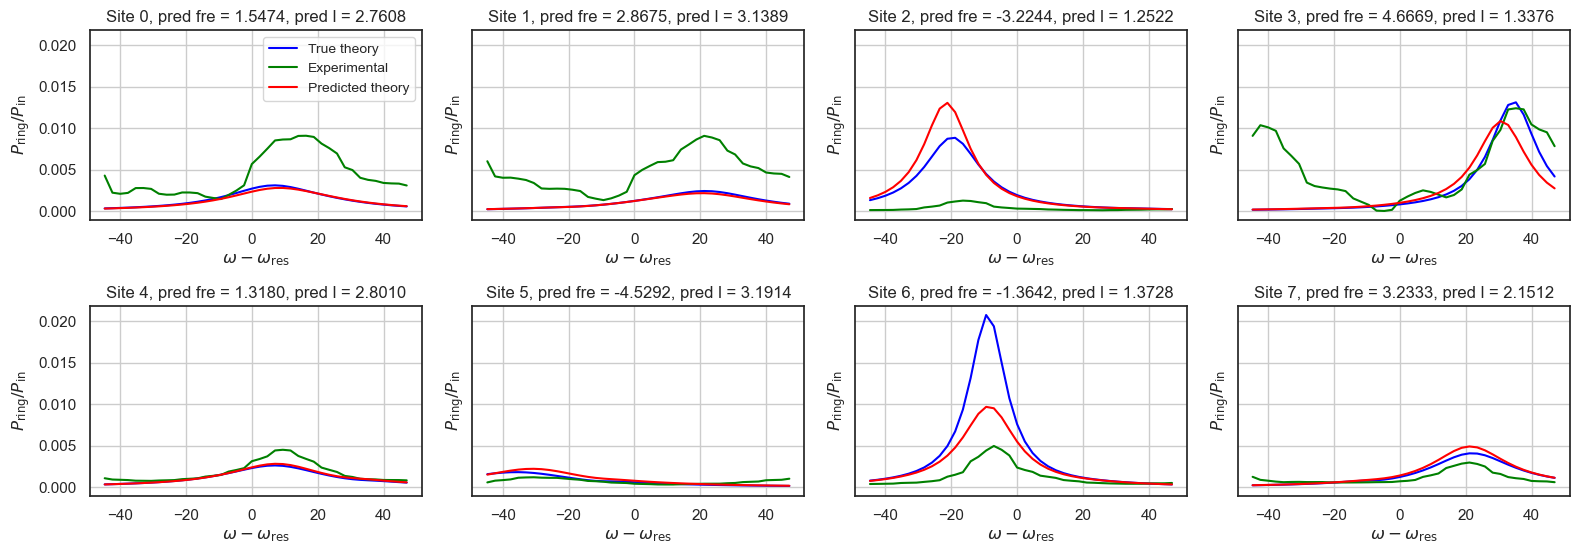

In [29]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)
#fig.suptitle("Experimental vs Theoretical Spectra", fontsize=16)

k = 15 #0 to 39
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, X_true[i+(8*k), :], label='True theory', color='blue')
    ax.plot(frequencies, new_chosenX_combined[i+(8*k), :], label='Experimental', color='green')
    ax.plot(frequencies, X_predicted[i+(8*k), :], label='Predicted theory', color='red')

    #ax.set_title(f"Site {i}, sample {k+1}")
    #ax.set_title(f"Site {i}, true fre = {y_true_f1[k,i]:.4f}, pred fre = {y_pred_f1[k,i]:.4f}, true l = {y_true_l1[k,i]:.4f}, pred l = {y_pred_l1[k,i]:.4f}")
    ax.set_title(f"Site {i}, pred fre = {y_pred_f1[k,i]:.4f}, pred l = {y_pred_l1[k,i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()

In [30]:
# Create neural network model
from tensorflow.keras import layers, Model, Input

def create_model_for_sanity_check(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    x = Dense(64, activation="relu", kernel_initializer="glorot_uniform")(x_input)
    x = Dense(64, activation="relu", kernel_initializer="glorot_uniform")(x)
    x = Dense(40, activation="linear")(x)  # Output dimension is 40
    model = Model(inputs=x_input, outputs=x)
    return model

def create_model_for_sanity_check1(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    
    x = Dense(128, activation="relu", kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.001))(x_input)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation="relu", kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    
    x = Dense(40, activation="linear")(x)  # Output dimension is 40 for regression
    
    model = Model(inputs=x_input, outputs=x)
    return model

def create_stage2_cnn(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    x = layers.Conv1D(64, 7, activation='relu', padding='same')(x_input)
    x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(input_shape[0], activation='linear')(x)
    return Model(inputs=x_input, outputs=x)

from tensorflow.keras import regularizers

def create_stage2_cnn1(input_shape):
    l2_reg = 1e-3  # Adjust if needed

    x_input = Input(shape=input_shape, name="x_input")

    x = layers.Conv1D(64, 7, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(128, 5, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(128, 5, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    output = layers.Dense(input_shape[0], activation='linear')(x)

    return Model(inputs=x_input, outputs=output)

In [31]:
new_X = X_predicted
new_Y = new_chosenX_combined[:1528]
print(new_X.shape,new_Y.shape)
new_X_train, new_X_test, new_y_train, new_y_test, y_f1_train, y_f1_test,y_l1_train, y_l1_test= train_test_split(new_X, new_Y,y_pred_f1.flatten(),y_pred_l1.flatten(), test_size=0.2)
print(new_X_train.shape)
print(new_X_test.shape)

(1528, 40) (1528, 40)
(1222, 40)
(306, 40)


In [32]:
scalernx = StandardScaler()
new_X_train_scaled = scalernx.fit_transform(new_X_train)
new_X_test_scaled = scalernx.transform(new_X_test)
#new_X_train_scaled = new_X_train
#new_X_test_scaled = new_X_test

scalerny = StandardScaler()
new_y_train_scaled = scalerny.fit_transform(new_y_train)
new_y_test_scaled = scalerny.transform(new_y_test)
#new_y_train_scaled = new_y_train
#new_y_test_scaled = new_y_test

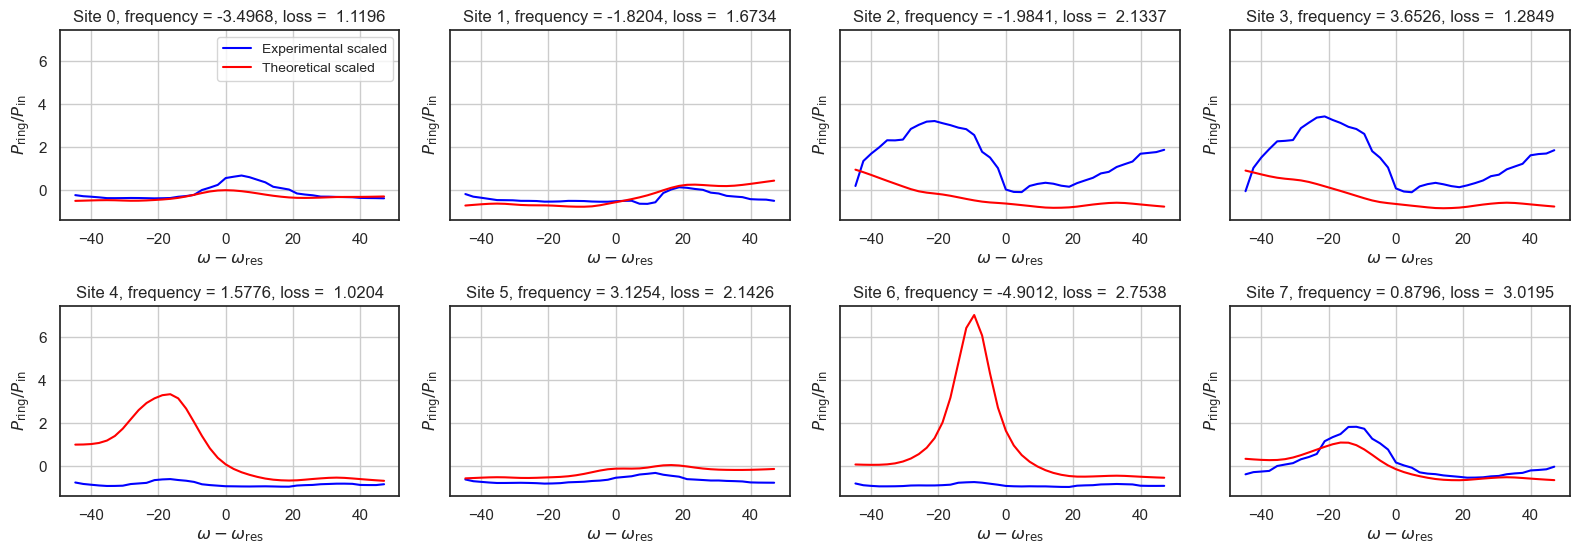

In [33]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 7
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, new_y_train_scaled[i+(8*k), :], label='Experimental scaled', color='blue')
    ax.plot(frequencies, new_X_train_scaled[i+(8*k), :], label='Theoretical scaled', color='red')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, frequency = {y_f1_train[k+i]:.4f}, loss =  {y_l1_train[k+i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()


In [34]:
new_X_train_scaled_cnn = new_X_train_scaled[..., np.newaxis]
new_X_test_scaled_cnn  = new_X_test_scaled[..., np.newaxis]

# Build CNN model
model_sc = create_stage2_cnn1(input_shape=new_X_train_scaled_cnn.shape[1:])
model_sc.compile(optimizer="adam", loss="mse")


# Train
history_sc = model_sc.fit(new_X_train_scaled_cnn, new_y_train_scaled,epochs=150, batch_size=25, validation_split=0.2)




Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9653 - val_loss: 1.4508
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0394 - val_loss: 1.4840
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9034 - val_loss: 1.5151
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8290 - val_loss: 1.5514
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6784 - val_loss: 1.5403
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5009 - val_loss: 1.6143
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5401 - val_loss: 1.5304
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4654 - val_loss: 1.4658
Epoch 9/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3314 - val_loss: 1.4744
Epoch 10/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2789 - val_loss: 1.4627
Epoch 11/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2246 - val_loss: 1.3278
Epoch 12/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.

Epoch 69/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7235 - val_loss: 0.8340
Epoch 70/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6571 - val_loss: 0.8323
Epoch 71/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6941 - val_loss: 0.8556
Epoch 72/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7165 - val_loss: 0.8604
Epoch 73/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7183 - val_loss: 0.8320
Epoch 74/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7470 - val_loss: 0.8800
Epoch 75/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7933 - val_loss: 0.8594
Epoch 76/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7440 - val_loss: 0.9566
Epoch 77/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7648 - val_loss: 0.8373
Epoch 78/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7169 - val_loss: 0.8898
Epoch 79/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7118 - val_loss: 0.8839
Epoch 80/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6818 - val_loss: 0.8722
Epoch 137/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6815 - val_loss: 0.8432
Epoch 138/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7234 - val_loss: 1.0233
Epoch 139/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7046 - val_loss: 0.8689
Epoch 140/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6759 - val_loss: 0.8483
Epoch 141/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6969 - val_loss: 0.8323
Epoch 142/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7045 - val_loss: 0.8456
Epoch 143/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7017 - val_loss: 0.8343
Epoch 144/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6825 - val_loss: 0.9573
Epoch 145/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6704 - val_loss: 0.8202
Epoch 146/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7238 - val_loss: 0.8030
Epoch 147/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11

In [35]:

# Evaluate
loss1 = model_sc.evaluate(new_X_test_scaled_cnn, new_y_test_scaled)
print(f"Test Loss: {loss1:.6f}")

#loss1 = model1.evaluate(new_X_test_scaled, new_y_test_scaled)
#print(f"Test Loss (noise_std={noise_std}):", loss)

# Predictions
new_y_pred_test = model_sc.predict(new_X_test_scaled)
new_y_pred_train = model_sc.predict(new_X_train_scaled)

print(new_y_pred_train.shape)
print(new_y_train.shape)
print(new_y_pred_test.shape)
print(new_y_test.shape)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7282 
Test Loss: 0.739659
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(1222, 40)
(1222, 40)
(306, 40)
(306, 40)


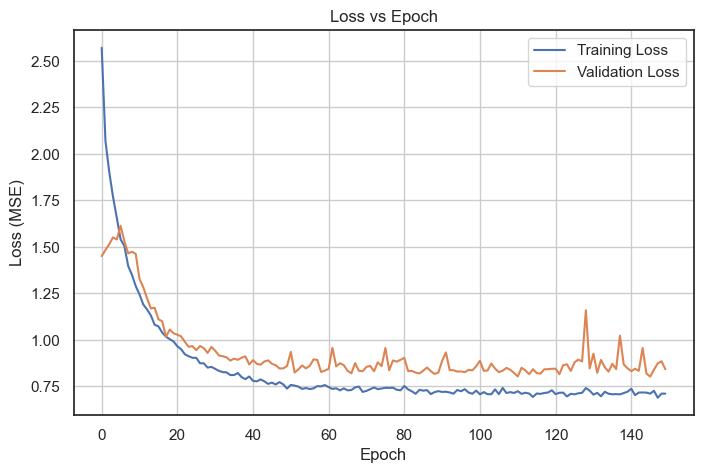

In [36]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
train_loss = history_sc.history['loss']
val_loss = history_sc.history['val_loss']

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
pred_y_train = scalerny.inverse_transform(new_y_pred_train)
pred_y_test = scalerny.inverse_transform(new_y_pred_test)

#pred_y_train = new_y_pred_train
#pred_y_test = new_y_pred_test

true_y_train = new_y_train
true_y_test = new_y_test

In [40]:
import numpy as np

def distance_label(a, b):
    a = np.asarray(a)
    b = np.asarray(b)

    # points: (a[i], b[i])
    dist = np.sqrt(a**2 + b**2)

    # ranks (1 = closest to origin)
    order = np.argsort(dist)
    c = np.empty_like(order)
    c[order] = np.arange(1, len(dist) + 1)

    return c
x = y_l1_test
y = y_f1_test
c = distance_label(x, y)
print(c)

[289 126  63 120 276 146 242 252 294 209  36 237 104 148 251 204 113 231
 285 141 110 241  48 302 144  91 281 112  17 250 131 181 125  86 101 239
 152   9 216 189  54 198  19  32 286  42 258 134  35  82  25  21  55  47
 300 127 121 128 153 197  11 165 232  87 262 178  62 293 287  97 100  72
 233 234  83  84 277   1  44 264  75 176  77 245 129 255 194 158  50 196
 195 306  29 160  94 192 291 157  23 115 225 295  81 114 279 217 271 283
 273   7  67 215 269 175 301 292 106 212 162 135 200 296 265  70 109  12
 177  14 268  16 210  88 180 261 218 282  56  60 207 108 220 249  51 254
 167 124 222 143 275 174 263  24  20 170 184 202  15 303 214 145 140  85
 190 159  13 151 138 298 130 156  96 123  68 111 150  61  64 136 246 133
  46 171 154 206  34   5 228  79  69 253 208 164  78 266 257  28  26 191
  40  33 205  95 118 256 169 240 201   4 211 247  37 119 305 219  18 155
 223  76  39 142  98 168 103  41 297 107 186  52 270 299  58 122 166 193
 147 161 243  43 280 244 227 203  31 179  80 185  2

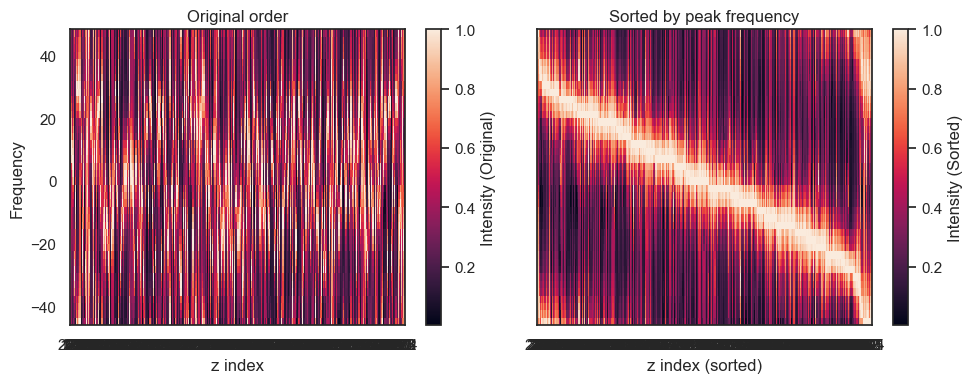

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# --- Example data ---
z = np.array(c)
frequencies1 = np.array(frequencies)
#S = np.array(true_y_test)
S = true_y_test / np.max(true_y_test, axis=1, keepdims=True)


# --- Sorting by where each row peaks ---
def sort_by_peak_frequency(z, S):
    peak_idx = np.argmax(S, axis=1)
    peak_amp = S[np.arange(S.shape[0]), peak_idx]
    order = np.lexsort((-peak_amp, peak_idx))
    return z[order], S[order, :], order

z_new, S_new, order = sort_by_peak_frequency(z, S)

# numeric z positions for plotting
z_numeric     = np.arange(len(z))
z_numeric_new = np.arange(len(z_new))

# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies1, S.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies1, S_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()


In [46]:
#Sk = np.array(pred_y_test)
Sk = pred_y_test/ np.max(pred_y_test, axis=1, keepdims=True)

Sk_new = Sk[order, :]

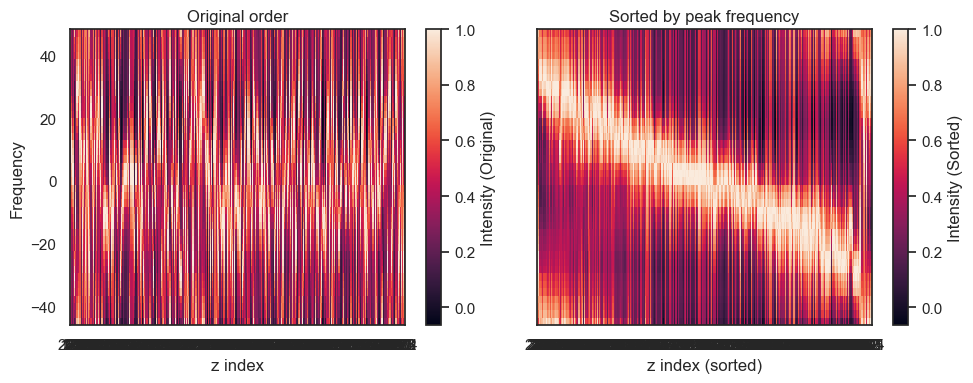

In [47]:
# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies, Sk.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies, Sk_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [48]:
import numpy as np

# Suppose we already have:
# z_sorted : shape (N,) = (320,)
# frequencies : shape (F,) = (40,)
# S_sorted : shape (N, F)
# Sk_sorted : shape (N, F)

# --- Flatten to long table (z, freq, S, Sk) ---
N, F = S_new.shape

# Repeat z along each frequency
z_col0 = np.repeat(z_new + 0.5, F) 
z_col = np.repeat(z_numeric_new + 0.5, F)              # (N*F,)
# Tile frequencies for each z
f_col = np.tile(frequencies, N)             # (N*F,)

# Flatten spectra values
S_col  = S_new.flatten(order="C")        # (N*F,)
Sk_col = Sk_new.flatten(order="C")       # (N*F,)

# Stack into one 2D array
data = np.column_stack([z_col0,z_col, f_col, S_col, Sk_col])

# --- Save to file ---
header = "z_sorted\tz_sorted_numeric\tfrequency\tS_sorted\tSk_sorted"
np.savetxt(
    "out_by_m/spectra_sorted_new.dat",
    data,
    fmt="%.10g",
    delimiter="\t",
    header=header,
    comments=""
)

print("✅ Saved spectra_sorted.dat with shape", data.shape)

✅ Saved spectra_sorted.dat with shape (12240, 5)


"Stop here below is hilbert space fitting"

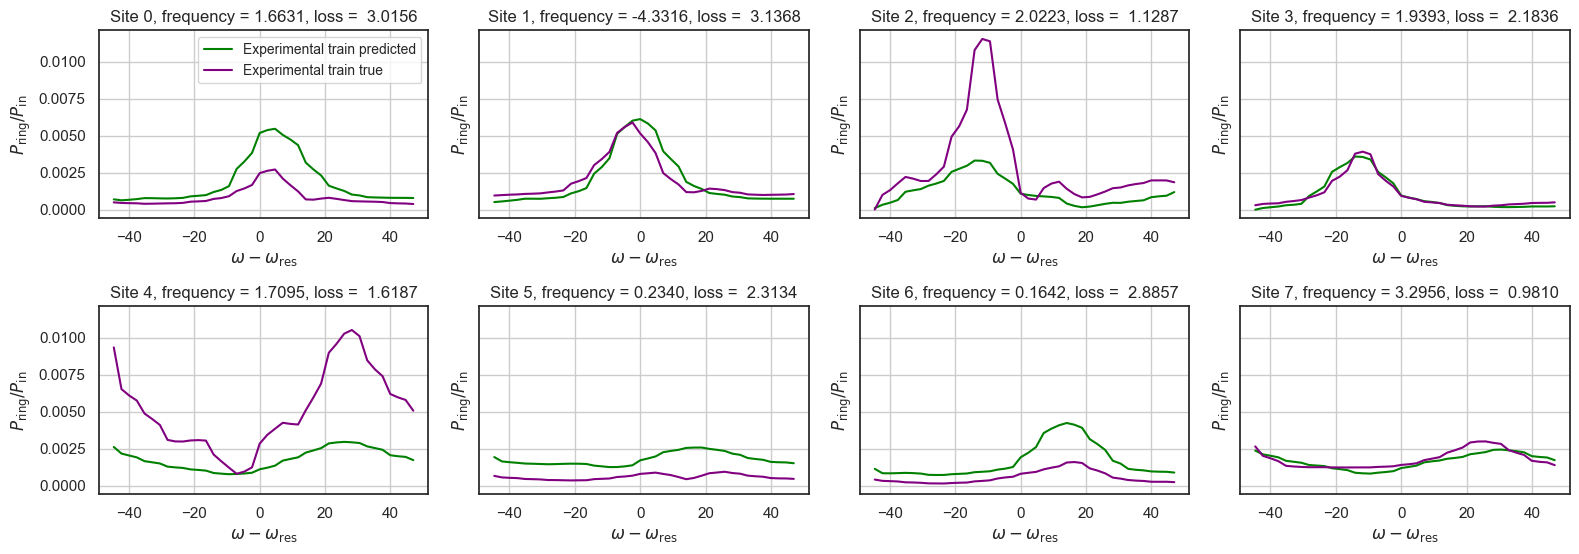

In [38]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 18
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, pred_y_train[i+(8*k), :], label='Experimental train predicted', color='green')
    ax.plot(frequencies, true_y_train[i+(8*k), :], label='Experimental train true', color='purple')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, frequency = {y_f1_train[k+i]:.4f}, loss =  {y_l1_train[k+i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()

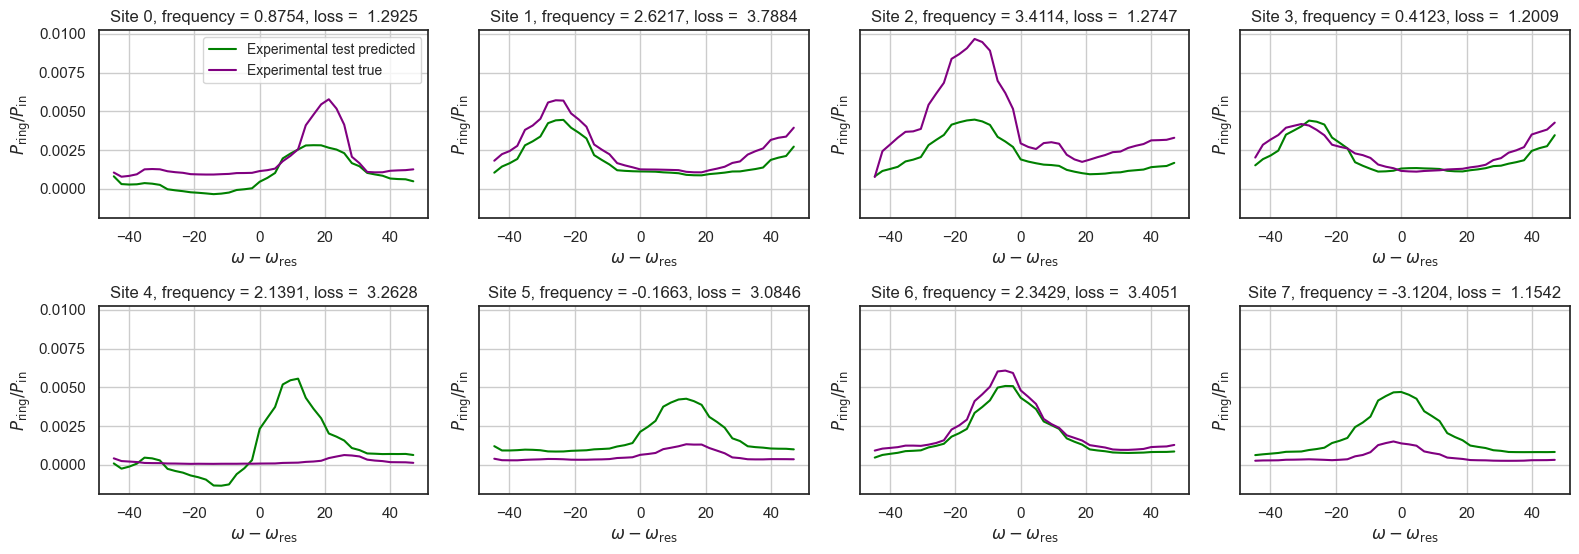

In [39]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k =25

for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, pred_y_test[i+(8*k), :], label='Experimental test predicted', color='green')
    ax.plot(frequencies, true_y_test[i+(8*k), :], label='Experimental test true', color='purple')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, frequency = {y_f1_test[k+i]:.4f}, loss =  {y_l1_test[k+i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()

In [40]:
import numpy as np

# ---------- Hilbert utils ----------
def _rot(n, x, y, rx, ry):
    if ry == 0:
        if rx == 1:
            x = n - 1 - x
            y = n - 1 - y
        x, y = y, x
    return x, y

def _xy2d(n, x, y):
    d = 0
    s = n // 2
    while s > 0:
        rx = 1 if (x & s) else 0
        ry = 1 if (y & s) else 0
        d += s * s * ((3 * rx) ^ ry)
        x, y = _rot(s, x, y, rx, ry)
        s //= 2
    return d

# -----------------------------------

def hilbert_xyz_any_sign(x, y, k=16):
    """
    Forward + backward mapping between real (x,y) and Hilbert z.
    Works for negative x,y.
    Returns (x_scaled, y_scaled, z)
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    assert x.shape == y.shape

    # Normalize
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    xr = (x - x_min) / (x_max - x_min + 1e-15)
    yr = (y - y_min) / (y_max - y_min + 1e-15)

    N = 1 << k
    scale = N - 1
    xi = np.clip((xr * scale).round().astype(np.uint32), 0, scale)
    yi = np.clip((yr * scale).round().astype(np.uint32), 0, scale)

    # Hilbert index
    z = np.fromiter((_xy2d(N, int(a), int(b)) for a, b in zip(xi, yi)),
                    dtype=np.uint64, count=len(xi))
    z_scaled = (z - z.min()) / (z.max() - z.min())
    return x, y, z_scaled

In [41]:
x = y_l1_test
y = y_f1_test
x1, y1, z1 = hilbert_xyz_any_sign(x, y, k=10)

In [42]:
assert len(np.unique(y, axis=0)) == len(np.unique(z1))
print(len(np.unique(z1)),len(z1))

306 306


In [56]:
import os
import numpy as np

def save_by_m(frequencies, pred_y_test, true_y_test, datay1_test,
              out_dir="out_by_m", delimiter="\t"):
    """
    Save 8 files, one for each m in [0..7], aggregating over all k.
    Each file has columns:
        k, m, freq, pred, true, loss

    Shapes assumed (consistent with your original indexing):
      - frequencies: (F,)
      - pred_y_test / true_y_test: stacked as idx = m + 8*k, each row length F
      - datay1_test: shape (K, 8) giving the 'loss' per (k, m)
    """
    os.makedirs(out_dir, exist_ok=True)
    F = frequencies.shape[0]
    K = datay1_test.shape[0]

    for m in range(8):
        rows = []
        for k in range(K):
            idx = m + 8 * k
            hilbval = float(datay1_test[k, m])
            block = np.column_stack([
                np.full(F, k, dtype=int),     # k
                np.full(F, m, dtype=int),     # m (constant within this file)
                frequencies,                  # freq
                pred_y_test[idx],             # pred
                true_y_test[idx],             # true
                np.full(F, hilbval, dtype=float) # hilbval (per k,m)

            ])
            rows.append(block)

        M = np.vstack(rows)
        out_path = os.path.join(out_dir, f"m{m}_allk_freq_pred_true_loss.dat")
        header = "k\tm\tfreq\tpred\ttrue\thilbval"
        np.savetxt(out_path, M,
                   fmt=["%d","%d","%.10g","%.10g","%.10g","%.10g"],
                   delimiter=delimiter, header=header, comments="")
        print(f"Saved {out_path} | shape={M.shape}")


In [57]:
from scipy.interpolate import interp1d
pred_y_test=pred_y_test[0:304,:]
true_y_test=true_y_test[0:304,:]

N = pred_y_test.shape[0]
z = z1[0:304].copy()
order = np.argsort(z)
z_sorted = z[order]
Z_p = pred_y_test[order, :]                      # (N, F)
    
Z_t = true_y_test[order, :]                      # (N, F)


# Interpolate each frequency column onto uniform z
Z_uniform_t = np.empty_like(Z_t)

# Build a uniform z axis
z_uniform = np.linspace(z_sorted.min(), z_sorted.max(), N)

# Interpolate each frequency column onto uniform z
Z_uniform_p = np.empty_like(Z_p)
for j in range(Z_p.shape[1]):
    f = interp1d(z_sorted, Z_p[:, j], kind='linear', fill_value='extrapolate', assume_sorted=True)
    Z_uniform_p[:, j] = f(z_uniform)

for j in range(Z_t.shape[1]):
    f = interp1d(z_sorted, Z_t[:, j], kind='linear', fill_value='extrapolate', assume_sorted=True)
    Z_uniform_t[:, j] = f(z_uniform)

In [45]:
#save_by_m(
#    frequencies=frequencies,
#    pred_y_test=Z_uniform_p[0:304],
#    true_y_test=Z_uniform_t[0:304],
#    datay1_test=z_uniform[0:304].reshape(38,8),
#    out_dir="out_by_m_uniform"   # folder where the 8 files will be saved
#)

In [46]:
import numpy as np

def hilbert3d_index(coords, n_bits=10):
    """
    Vectorized John Skilling (2004) algorithm for 3D Hilbert index.
    coords : (N,3) uint32 in [0, 2^n_bits)
    returns : (N,) uint64 indices
    """
    if coords.shape[1] != 3:
        raise ValueError("coords must be (N,3)")
    Npts = coords.shape[0]
    x = coords.copy().astype(np.uint32)
    n = n_bits
    M = 1 << (n - 1)
    Q = M
    while Q > 1:
        P = Q - 1
        mask = (x[:, 0] & Q) != 0
        x[mask, 1] ^= P
        x[mask, 2] ^= P
        notmask = ~mask
        t = ((x[notmask, 1] ^ x[notmask, 2]) & P)
        x[notmask, 1] ^= t
        x[notmask, 2] ^= t
        Q >>= 1

    # Gray encode
    for i in range(1, 3):
        x[:, i] ^= x[:, i - 1]
    t = np.zeros(Npts, np.uint32)
    Q = 2
    while Q <= M:
        mask = (x[:, 2] & Q) != 0
        t[mask] ^= (Q - 1)
        Q <<= 1
    for i in range(3):
        x[:, i] ^= t

    # bit interleave
    z = np.zeros(Npts, np.uint64)
    for b in range(n):
        for i in range(3):
            z |= ((x[:, i] >> b).astype(np.uint64) & 1) << (3*b + i)
    return z

def hilbert_z_3d_reals(w, x, y, k=10):
    """Real (w,x,y) → 1D Hilbert index."""
    w = np.asarray(w, float); x = np.asarray(x, float); y = np.asarray(y, float)
    if not (w.shape == x.shape == y.shape):
        raise ValueError("w, x, y must have same length")

    def norm01(a):
        return (a - a.min()) / (a.max() - a.min() + 1e-15)

    wr, xr, yr = map(norm01, [w, x, y])
    Nlev = (1 << k) - 1
    coords = np.column_stack([
        np.clip(np.round(wr * Nlev), 0, Nlev),
        np.clip(np.round(xr * Nlev), 0, Nlev),
        np.clip(np.round(yr * Nlev), 0, Nlev)
    ]).astype(np.uint32)

    z = hilbert3d_index(coords, n_bits=k)
    z_scaled = (z - z.min()) / (z.max() - z.min() + 1e-20)
    return z, z_scaled



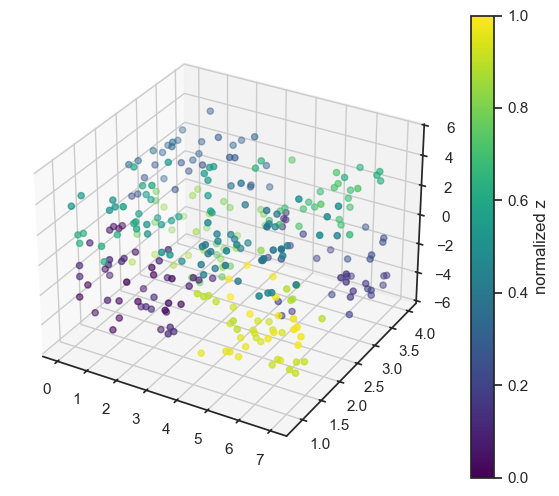

In [47]:
import matplotlib.pyplot as plt

R = 38
Nx = 8
w = np.arange(Nx)                     # 8 w-values
x = y_l1_test[0:304]   # 80 x-values
y = y_f1_test[0:304]# 80 y-values

w_pairs = np.repeat(w, R)
x_pairs = x.reshape(Nx, R).ravel()
y_pairs = y.reshape(Nx, R).ravel()

z3, z_scaled = hilbert_z_3d_reals(w_pairs, x_pairs, y_pairs, k=8)

# visualize
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(w_pairs, x_pairs, y_pairs, c=z_scaled, cmap='viridis', s=20)
plt.colorbar(sc, label="normalized z")
plt.show()

In [48]:
assert len(np.unique(y, axis=0)) == len(np.unique(z3))
print(len(np.unique(z3)),len(z3))

304 304


In [59]:
from scipy.interpolate import interp1d
pred_y_test=pred_y_test[0:304,:]
true_y_test=true_y_test[0:304,:]

N = pred_y_test.shape[0]
z = z3[0:304].copy()
order = np.argsort(z)
z_sorted = z[order]
Z_p = pred_y_test[order, :]                      # (N, F)
    
Z_t = true_y_test[order, :]                      # (N, F)


# Interpolate each frequency column onto uniform z
Z_uniform_t = np.empty_like(Z_t)

# Build a uniform z axis
z_uniform = np.linspace(z_sorted.min(), z_sorted.max(), N)

# Interpolate each frequency column onto uniform z
Z_uniform_p = np.empty_like(Z_p)
for j in range(Z_p.shape[1]):
    f = interp1d(z_sorted, Z_p[:, j], kind='linear', fill_value='extrapolate', assume_sorted=True)
    Z_uniform_p[:, j] = f(z_uniform)

for j in range(Z_t.shape[1]):
    f = interp1d(z_sorted, Z_t[:, j], kind='linear', fill_value='extrapolate', assume_sorted=True)
    Z_uniform_t[:, j] = f(z_uniform)

In [60]:
import numpy as np

def save_all_km_single(frequencies, pred_y_test, true_y_test,
                       datay1_test=None,  # optional: loss per (k,m)
                       z=None,            # optional: Hilbert-curve value(s)
                       out_path="all_k_m_freq_pred_true_loss_z.dat",
                       delimiter="\t"):
    """
    Save ONE file stacking all k and m (0..7) over all frequencies.
    Columns: k, m, freq, pred, true, loss, z

    Assumptions:
      - frequencies: shape (F,)
      - pred_y_test / true_y_test are stacked with idx = m + 8*k, each row length F
      - If datay1_test is provided: shape (K, 8) giving 'loss' per (k,m)
      - z can be:
          * None -> column filled with NaN
          * shape (K, 8) -> scalar per (k,m), broadcast across F
          * shape (K, 8, F) -> value per (k,m,f)
    """
    frequencies = np.asarray(frequencies)
    F = frequencies.shape[0]

    pred_y_test = np.asarray(pred_y_test)
    true_y_test = np.asarray(true_y_test)

    # infer K from stacked rows length
    if pred_y_test.ndim != 2 or pred_y_test.shape[1] != F:
        raise ValueError("pred_y_test must be 2D with shape (8*K, F)")
    if true_y_test.shape != pred_y_test.shape:
        raise ValueError("true_y_test shape must match pred_y_test")

    rows_stacked = pred_y_test.shape[0]
    if rows_stacked % 8 != 0:
        raise ValueError("pred_y_test rows not divisible by 8; cannot infer K")
    K = rows_stacked // 8

    # prepare loss
    if datay1_test is None:
        datay1_test = np.full((K, 8), np.nan, dtype=float)
    else:
        datay1_test = np.asarray(datay1_test)
        if datay1_test.shape != (K, 8):
            raise ValueError(f"datay1_test must have shape (K, 8) = ({K}, 8)")

    # prepare z
    z_mode = "none"
    if z is None:
        # fill later with NaN
        pass
    else:
        z = np.asarray(z)
        if z.shape == (K, 8):
            z_mode = "km"
        elif z.shape == (K, 8, F):
            z_mode = "kmf"
        else:
            raise ValueError(f"z must have shape (K,8) or (K,8,F); got {z.shape}")

    blocks = []
    for k in range(K):
        for m in range(8):
            idx = m + 8 * k
            loss_km = float(datay1_test[k, m])

            # choose z column for this (k,m)
            if z_mode == "none":
                z_col = np.full(F, np.nan, dtype=float)
            elif z_mode == "km":
                z_col = np.full(F, float(z[k, m]), dtype=float)
            else:  # "kmf"
                z_col = z[k, m].astype(float)

            block = np.column_stack([
                np.full(F, k, dtype=int),          # k
                np.full(F, m, dtype=int),          # m
                frequencies,                       # freq
                pred_y_test[idx],                  # pred
                true_y_test[idx],                  # true
                np.full(F, loss_km, dtype=float),  # loss
                z_col                               # z
            ])
            blocks.append(block)

    M = np.vstack(blocks)

    header = "k\tm\tfreq\tpred\ttrue\tloss\tz"
    np.savetxt(out_path, M,
               fmt=["%d","%d","%.10g","%.10g","%.10g","%.10g","%.10g"],
               delimiter=delimiter, header=header, comments="")
    print(f"Saved {out_path} | shape={M.shape} | K={K}, F={F}")


In [61]:
K = 38                             # number of k’s
F = frequencies.shape[0]            # number of frequency samples

# z_flat has length 8*K (320). Match idx = m + 8*k  → row=k, col=m
z_km = z_uniform.reshape(K, 8)         # shape (K, 8): z[k, m]

# (Optional) quick sanity check: z_km[k, m] == z_flat[m + 8*k]
# assert np.allclose(z_km.ravel(order="C"), z_flat)

#save_all_km_single(
#    frequencies=frequencies,        # shape (F,)
#    pred_y_test=Z_uniform_p,        # shape (8*K, F) stacked with idx = m + 8*k
#    true_y_test=Z_uniform_t,        # shape (8*K, F) same stacking
#    z=z_km/np.max(z_km),                         # shape (K, 8) → broadcast across frequencies
#    out_path="out_by_m_uniform/all_km_freq_pred_true_loss_z1.dat"
#)


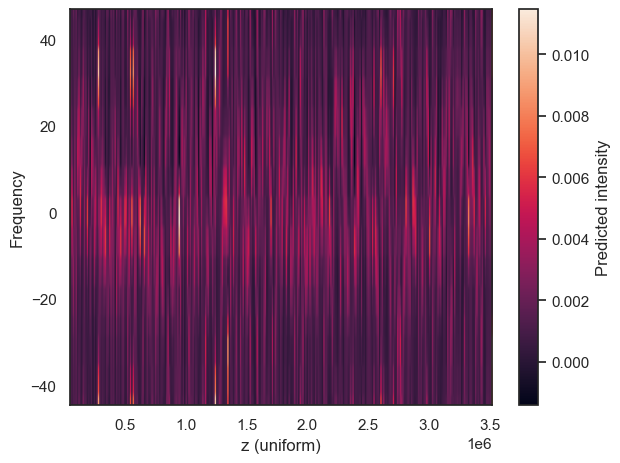

In [65]:
from scipy.interpolate import interp1d
pred_y_test=pred_y_test[0:304,:]
true_y_test=true_y_test[0:304,:]

N = pred_y_test.shape[0]
z = z_uniform.copy()
order = np.argsort(z)
z_sorted = z[order]
Z_p = pred_y_test[order, :]                      # (N, F)

# Build a uniform z axis
z_uniform = np.linspace(z_sorted.min(), z_sorted.max(), N)

# Interpolate each frequency column onto uniform z
Z_uniform_p = np.empty_like(Z_p)
for j in range(Z_p.shape[1]):
    f = interp1d(z_sorted, Z_p[:, j], kind='linear', fill_value='extrapolate', assume_sorted=True)
    Z_uniform_p[:, j] = f(z_uniform)

plt.figure()
plt.imshow(Z_uniform_p.T, aspect='auto',
           extent=[z_uniform.min(), z_uniform.max(), frequencies.min(), frequencies.max()],
           origin='lower')
plt.xlabel('z (uniform)')
plt.ylabel('Frequency')
plt.colorbar(label='Predicted intensity')
plt.tight_layout()
plt.show()


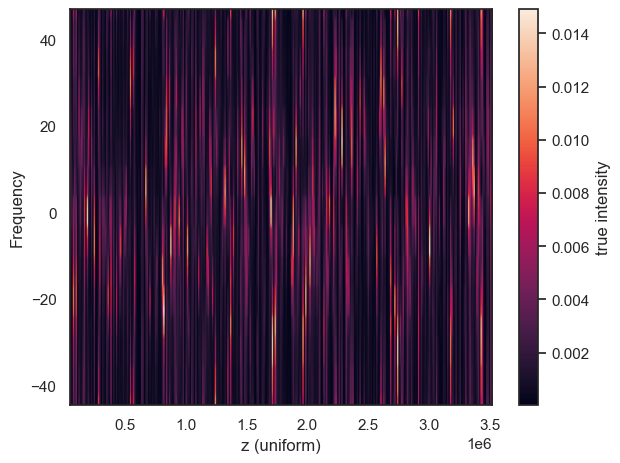

In [66]:
from scipy.interpolate import interp1d

Z_t = true_y_test[order, :]                      # (N, F)


# Interpolate each frequency column onto uniform z
Z_uniform_t = np.empty_like(Z_t)
for j in range(Z_t.shape[1]):
    f = interp1d(z_sorted, Z_t[:, j], kind='linear', fill_value='extrapolate', assume_sorted=True)
    Z_uniform_t[:, j] = f(z_uniform)

plt.figure()
plt.imshow(Z_uniform_t.T, aspect='auto',
           extent=[z_uniform.min(), z_uniform.max(), frequencies.min(), frequencies.max()],
           origin='lower')
plt.xlabel('z (uniform)')
plt.ylabel('Frequency')
plt.colorbar(label='true intensity')
plt.tight_layout()
plt.show()

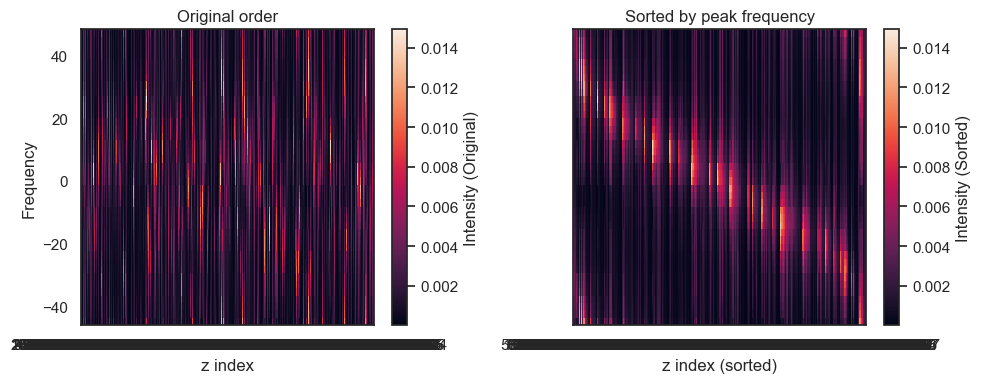

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# --- Example data ---
z = np.array(z_uniform)
frequencies1 = np.array(frequencies)
S = np.array(true_y_test)

# --- Sorting by where each row peaks ---
def sort_by_peak_frequency(z, S):
    peak_idx = np.argmax(S, axis=1)
    peak_amp = S[np.arange(S.shape[0]), peak_idx]
    order = np.lexsort((-peak_amp, peak_idx))
    return z[order], S[order, :], order

z_new, S_new, order = sort_by_peak_frequency(z, S)

# numeric z positions for plotting
z_numeric     = np.arange(len(z))
z_numeric_new = np.arange(len(z_new))

# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies1, S.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies1, S_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()


In [53]:
Sk = np.array(pred_y_test)
Sk_new = Sk[order, :]

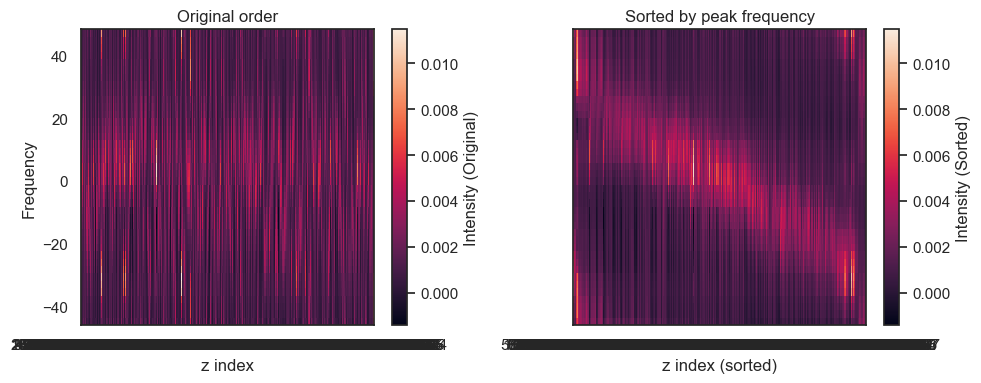

In [54]:
# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies, Sk.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies, Sk_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [55]:
import numpy as np

# Suppose we already have:
# z_sorted : shape (N,) = (320,)
# frequencies : shape (F,) = (40,)
# S_sorted : shape (N, F)
# Sk_sorted : shape (N, F)

# --- Flatten to long table (z, freq, S, Sk) ---
N, F = S_new.shape

# Repeat z along each frequency
z_col = np.repeat(z_numeric_new + 0.5, F)              # (N*F,)
# Tile frequencies for each z
f_col = np.tile(frequencies, N)             # (N*F,)

# Flatten spectra values
S_col  = S_new.flatten(order="C")        # (N*F,)
Sk_col = Sk_new.flatten(order="C")       # (N*F,)

# Stack into one 2D array
data = np.column_stack([z_col, f_col, S_col, Sk_col])

# --- Save to file ---
header = "z_sorted\tfrequency\tS_sorted\tSk_sorted"
np.savetxt(
    "out_by_m/spectra_sorted.dat",
    data,
    fmt="%.10g",
    delimiter="\t",
    header=header,
    comments=""
)

print("✅ Saved spectra_sorted.dat with shape", data.shape)


✅ Saved spectra_sorted.dat with shape (12160, 4)
